<a href="https://colab.research.google.com/github/Suchitra-V31/OPENCV/blob/main/Panorama_Stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Panorama Stitching**

Image stitching or photo stitching is the process of combining multiple photographic images with overlapping fields of view to produce a segmented panorama or high-resolution image.

Step #1: Detect keypoints (DoG, Harris, etc.) ...

Step #2: Match the descriptors between the two images.

Step #3: Use the RANSAC algorithm to estimate a homography matrix using our matched feature vectors.

Step #4: Apply a warping transformation using the homography matrix obtained from Step #3.



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
train_img = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
train_img_grey =cv2.cvtColor(train_img,cv2.COLOR_RGB2GRAY)

In [ ]:
query_img = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')
query_img_grey=cv2.cvtColor(query_img,cv2.COLOR_RGB2GRAY)

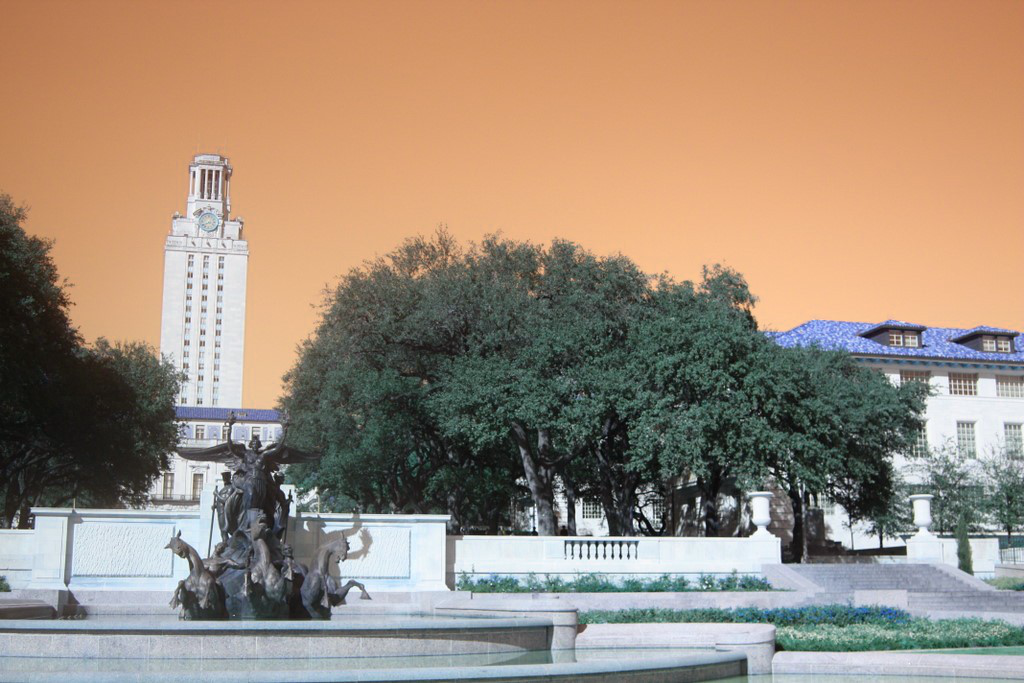

In [ ]:
#let us view the image
cv2_imshow(query_img)
#This is the query image

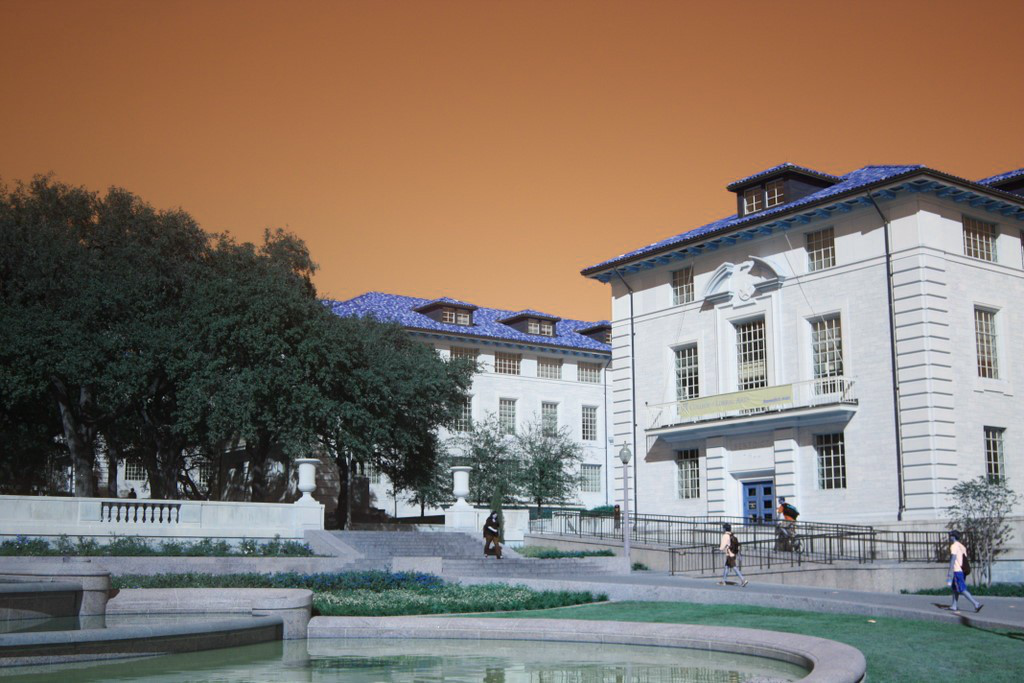

In [ ]:
cv2_imshow(train_img)
#This is the image that is need to be transformed

In [ ]:
#key detection
def detectAnddescribe(image,method=None):
  if method=='sift':
    descriptor=cv2.xfeatures2d.SIFT_create()
  elif method=='surf':
    descriptor=cv2.xfeatures2d.SURF_create()
  elif method=='brisk':
    descriptor=cv2.BRISK_create()
  elif method=='orb':
    descriptor=cv2.ORB_create()
  (kps,features)=descriptor.detectAndCompute(image,None) #getting keypoints and features
  return(kps,features)

In [ ]:
feature_extractor='orb'
feature_matching='bf'

In [ ]:
(kpsA,featuresA)=detectAnddescribe(train_img_grey,feature_extractor)
(kpsB,featuresB)=detectAnddescribe(query_img_grey,feature_extractor)

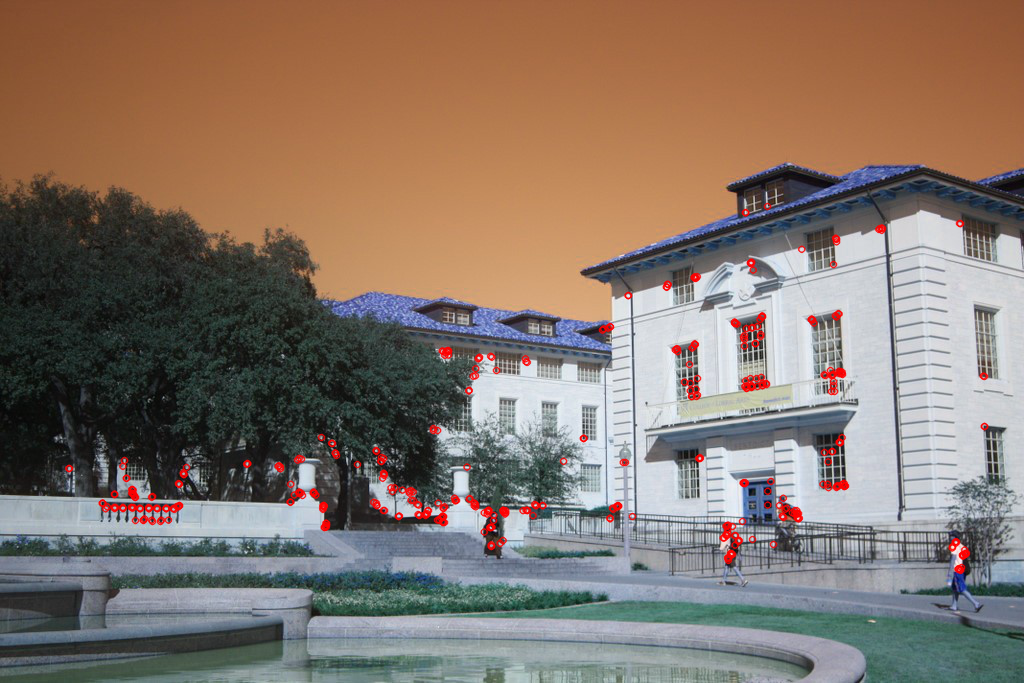

In [ ]:
#let us view the keypoints
cv2_imshow(cv2.drawKeypoints(train_img,kpsA,None,(0,0,255)))

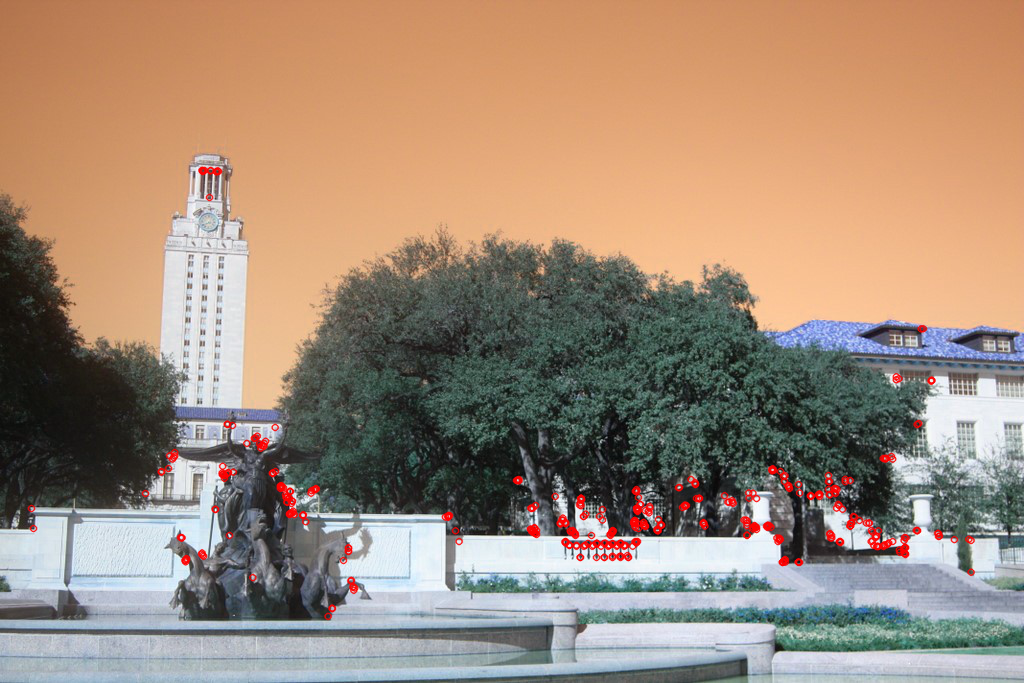

In [ ]:
cv2_imshow(cv2.drawKeypoints(query_img,kpsB,None,(0,0,255)))

In [ ]:
def createMatcher(method,crossCheck):
  if method=='sift' or method=='surf':
    bf=cv2.BFMatcher(cv2.NORM_L2,crossCheck=crossCheck)
  elif method=='orb' or method=='brisk':
    bf=cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=crossCheck)
  return bf

In [ ]:
def matchKeypointsBF(featuresA,featuresB,method):
  bf=createMatcher(feature_extractor,crossCheck=True)
  bf_match=bf.match(featuresA,featuresB)
  raw_matches=sorted(bf_match,key=lambda x:x.distance)
  print('Raw Matches: ',len(raw_matches))
  return raw_matches

In [ ]:
matches = matchKeypointsBF(featuresA, featuresB, method=feature_extractor)
img3 = cv2.drawMatches(train_img,kpsA,query_img,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

Raw Matches:  186


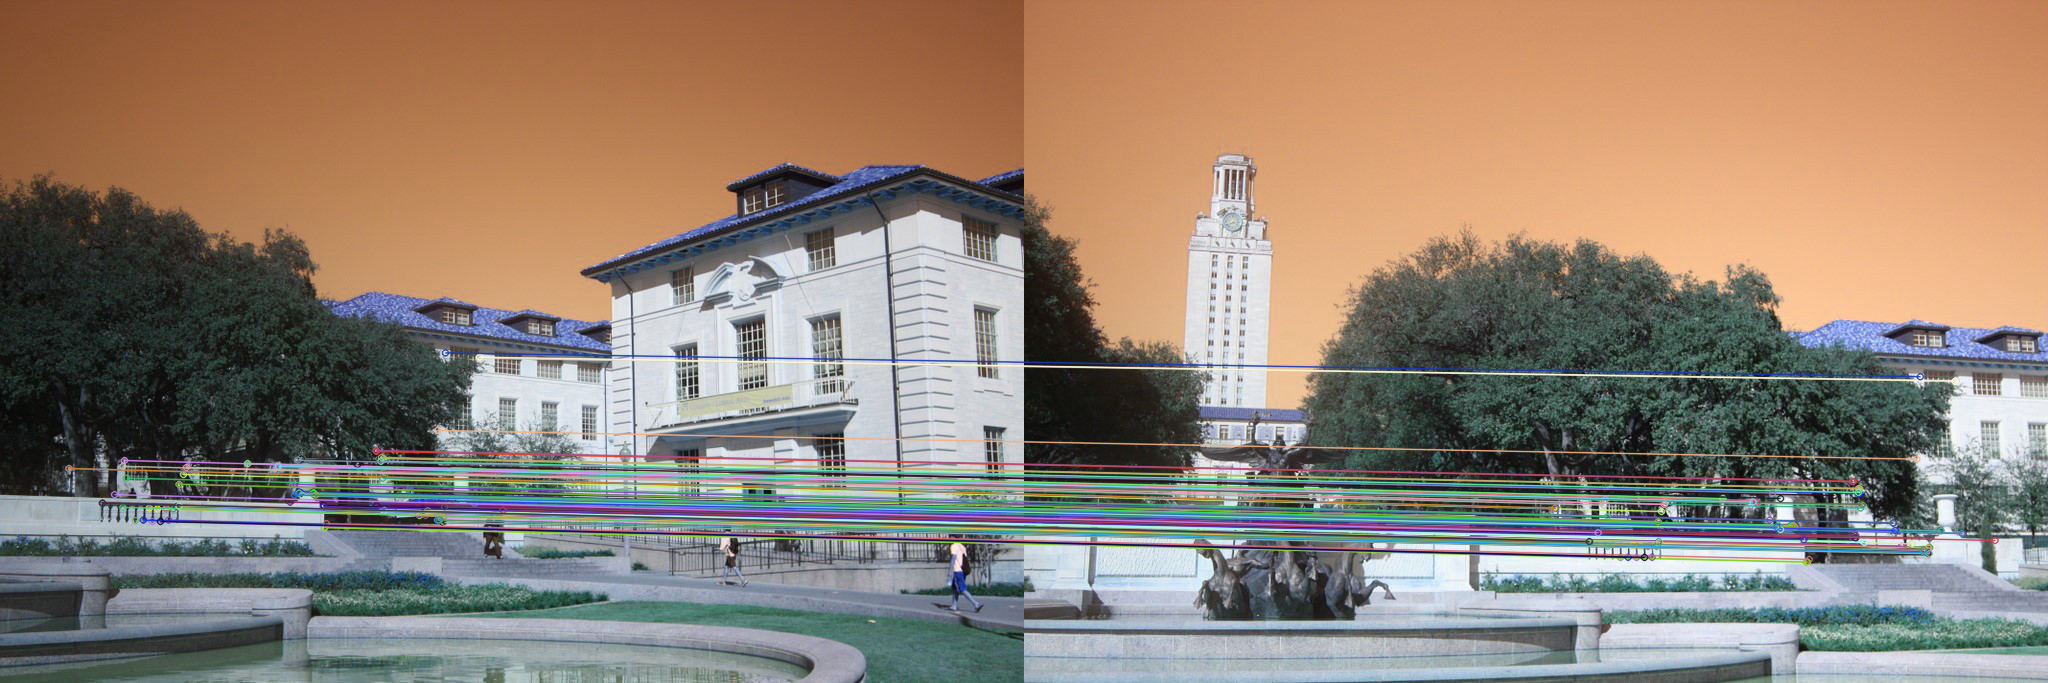

In [ ]:
cv2_imshow(img3)

In [ ]:
def getHomography(kpsA,kpsB,featuresA,featuresB,matches,reprojThresh):
  kpsA=np.float32([kp.pt for kp in kpsA])
  kpsB=np.float32([kp.pt for kp in kpsB])
  if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)
        return (matches,H,status)
  else:
      return None

In [ ]:
M=getHomography(kpsA,kpsB,featuresA,featuresB,matches,reprojThresh=4)
if M is None:
  print('Error!!')
(matches,H,status)=M
print(H)

[[ 8.18615992e-01  1.13260526e-01  4.27375823e+02]
 [-1.29788373e-01  9.97128543e-01  5.65078169e+01]
 [-2.01547290e-04  5.43423154e-05  1.00000000e+00]]


In [ ]:
# Apply panorama correction
width = train_img.shape[1] + query_img.shape[1]
height = train_img.shape[0] + query_img.shape[0]


result = cv2.warpPerspective(train_img, H, (width, height))
result[0:query_img.shape[0], 0:query_img.shape[1]] = query_img

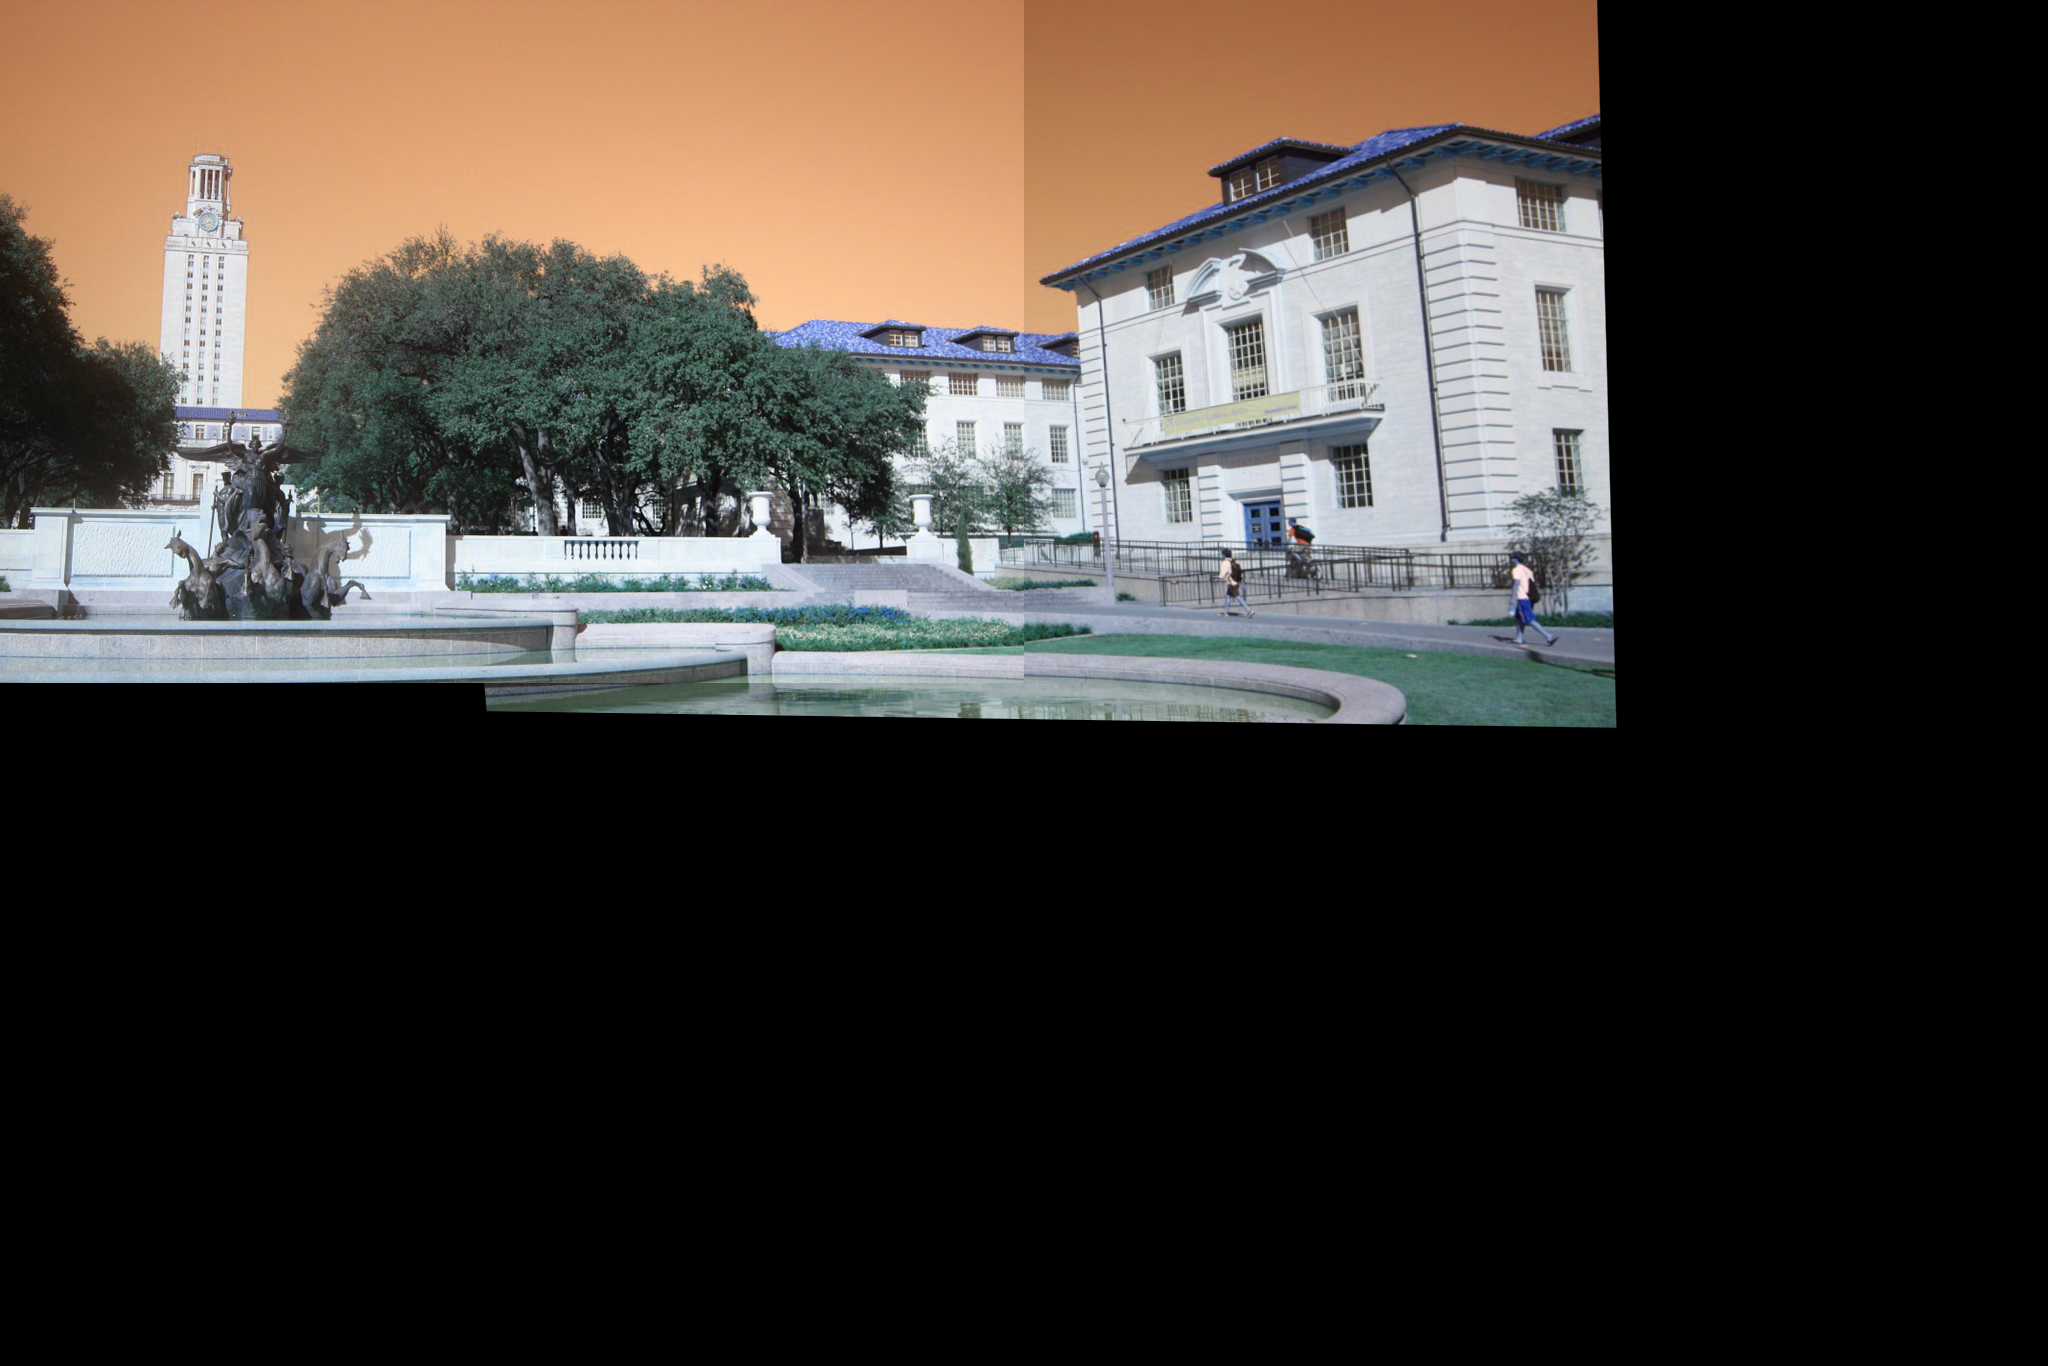

In [ ]:
cv2_imshow(result)

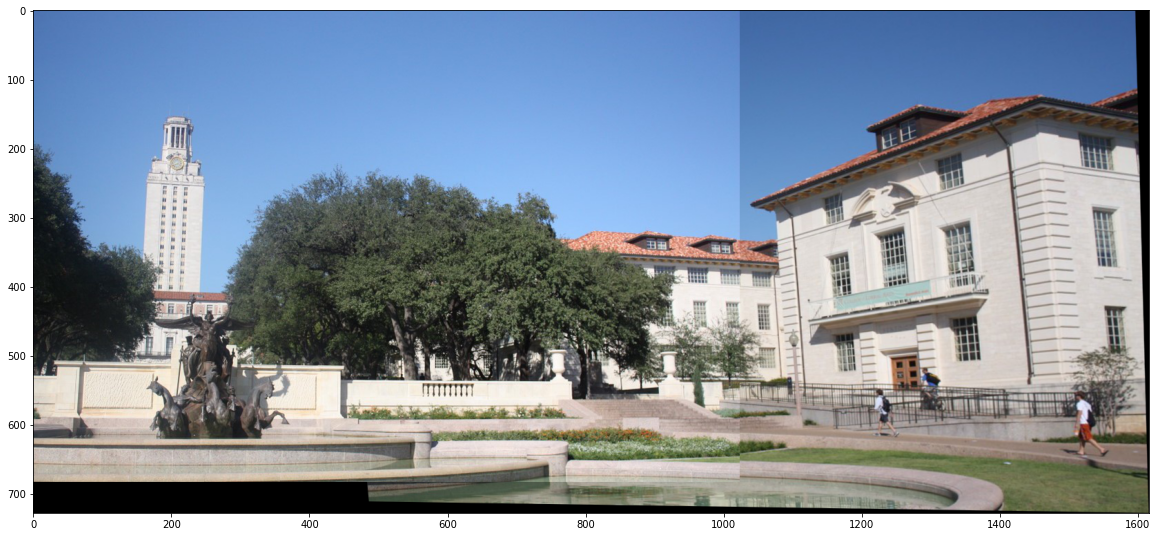

In [ ]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)